In [1514]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import transforms

In [1545]:
def pil_to_tensor(pil_image: Image) -> torch.tensor:
    return transforms.Compose([transforms.ToTensor()])(pil_image)

def read_image(image_name: str) -> torch.tensor:
    image = Image.open(image_name).convert('RGB')
    return pil_to_tensor(image)

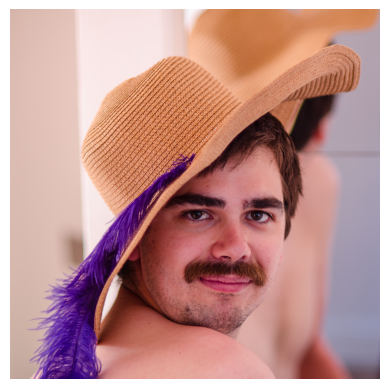

In [1546]:
def show_tensor_image(tensor_img: torch.tensor) -> None:
    plt.axis('off')
    plt.gray()
    
    assert 2 <= len(tensor_img.shape) <= 3, "Image should have two or three dimensions"
    if len(tensor_img.shape) == 3:
        plt.imshow(tensor_img.permute(1, 2, 0))
    else:
        plt.imshow(tensor_img)
    plt.show()

raw_image = read_image("Lenny_1024.png")
show_tensor_image(raw_image)

In [1547]:
def convert_to_grayscale(tensor_image: torch.tensor) -> torch.tensor:
    red = 0.299
    green = 0.587
    blue = 0.114
    weights = torch.Tensor([red, green, blue]).reshape(1, 3, 1, 1)
    greyscale_image = F.conv2d(tensor_image, weights)
    return greyscale_image

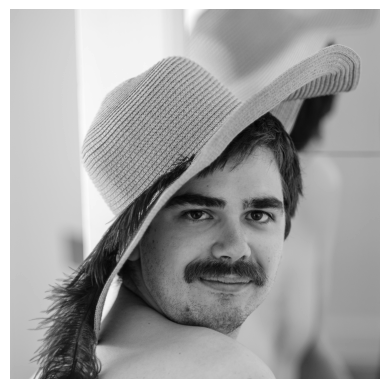

In [1548]:
img_greyscale = convert_to_grayscale(raw_image)
show_tensor_image(img_greyscale)

In [1549]:
def image_pooling(tensor_image: torch.tensor, method: str = "max") -> torch.tensor:
    assert method in ["max", "avg"], 'Possible pooling methods are ["max", "avg"]'
    pooling_fun = F.max_pool2d if method == "max" else F.avg_pool2d
    pooled_image = pooling_fun(tensor_image, kernel_size=4)
    return pooled_image

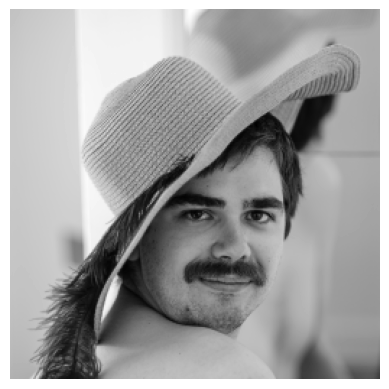

In [1550]:
img_pooled = image_pooling(img_greyscale, "avg")
show_tensor_image(img_pooled)

In [1551]:
def draw_kernel(kernel: torch.tensor) -> None:
    plt.axis('off')
    plt.imshow(kernel, cmap='magma')
    plt.show()

def create_gaussian_kernel(n: int, sigma: float = 1.0) -> torch.tensor:
    assert 0 < n and type(n) == int, "Kernel size should be a positive natural number"
    assert n % 2, "Kernel size should be an odd number"
    
    half = (n // 2)
    x = torch.arange(-half, half + 1)
    y = torch.arange(-half, half + 1)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
    denominator = 2*sigma**2
    normal = torch.exp(-(grid_x.square() + grid_y.square()) / denominator)
    normal = normal / normal.sum()
    return normal

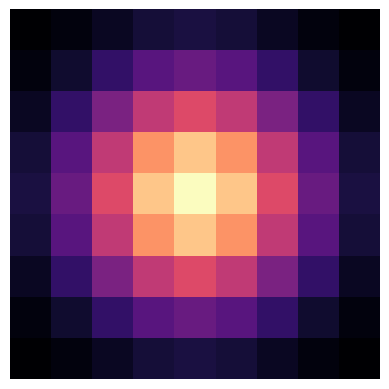

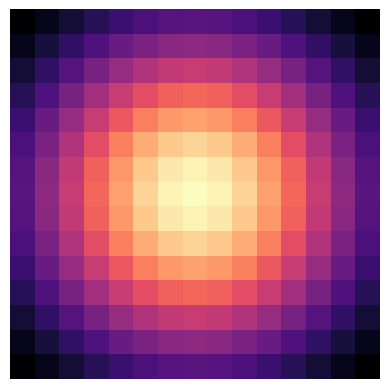

In [1552]:
draw_kernel(create_gaussian_kernel(9, sigma=2))
draw_kernel(create_gaussian_kernel(15, sigma=5))

In [1553]:
def gaussian_blur(grayscale_image: torch.tensor, kernel_size: int = 5, kernel_sigma: float = 0.1) -> torch.tensor:
    
    kernel = create_gaussian_kernel(kernel_size, kernel_sigma).unsqueeze(0).unsqueeze(0)
    blurred_image = F.conv2d(grayscale_image, kernel, stride=1, padding=kernel_size // 2)
    return blurred_image

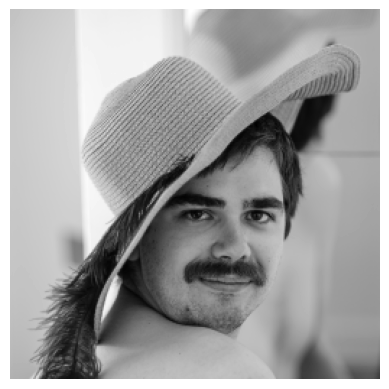

In [1554]:
img_blurred = gaussian_blur(img_pooled)
show_tensor_image(img_blurred)

In [1555]:
def create_sobel_filters():
    x_scan = torch.tensor([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1],
    ], dtype=torch.float)
    y_scan = x_scan.transpose(0, 1).flip(0)
    sobel_filters = torch.stack((y_scan, x_scan))
    return sobel_filters
    
    
def apply_sobel_filters(tensor_image: torch.Tensor):
    sobel_filters = create_sobel_filters().reshape(2, 1, 3, 3)
    filtered = F.conv2d(tensor_image, sobel_filters, stride=1, padding=1)
    
    norm_channel = (filtered.square().sum(axis=0)).sqrt()
    angle_channel = torch.atan2(*filtered)
    return norm_channel, angle_channel

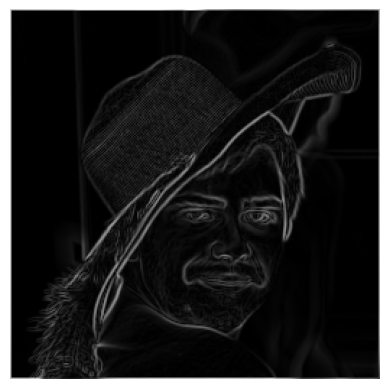

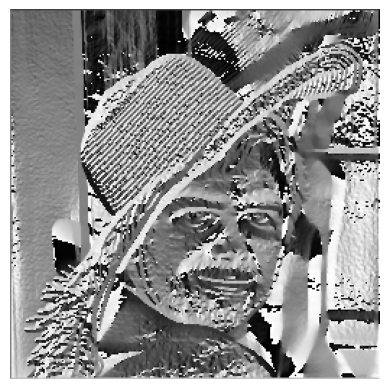

In [1556]:
norm, angle = apply_sobel_filters(img_blurred)
show_tensor_image(norm)
show_tensor_image(angle)

In [1557]:
def prepare_neighbor_filters() -> torch.tensor:
    filter_0_0 = torch.tensor([
        [0, 0, 0],
        [0, 1,-1],
        [0, 0, 0],
    ], dtype=torch.float)
    filter_0_1 = filter_0_0.flip(1)
    
    filter_45_0 = torch.tensor([
        [0, 0, -1],
        [0, 1, 0],
        [0, 0, 0],
    ],dtype=torch.float)
    filter_45_1 = filter_45_0.transpose(0, 1)
    
    filter_90_0 = filter_0_0.transpose(0, 1)
    filter_90_1 = filter_90_0.flip(0)

    filter_135_0 = torch.tensor([
        [-1, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
    ], dtype=torch.float)
    filter_135_1 = filter_135_0.flip(0).flip(1)
    
    filters = torch.stack((filter_0_0, filter_0_1, filter_45_0, filter_45_1, filter_90_0, filter_90_1, filter_135_0, filter_135_1)).reshape(8, 1, 3, 3)
    return filters

def prepare_angle_filters(angle: torch.tensor) -> torch.tensor:
    angle = angle * 180 / torch.pi
    angle[angle < 0] += 180
    angle = angle % 157.5
    
    angle_0 = (0 <= angle) & (angle < 22.5)
    angle_45 = (22.5 <= angle) & (angle < 67.5)
    angle_90 = (67.5 <= angle) & (angle < 112.5)
    angle_135 = (112.5 <= angle) & (angle < 157.5)
    
    angle_filters = torch.stack((angle_0, angle_45, angle_90, angle_135))
    
    return angle_filters
    
def non_max_suppression_vectorized(img: torch.tensor, angle: torch.tensor) -> torch.tensor:
    angle_filters = prepare_angle_filters(angle)
    neighbor_filters = prepare_neighbor_filters()
    
    neighbor_comp = F.relu(F.conv2d(img.unsqueeze(0), neighbor_filters, padding=1))
    output = neighbor_comp.reshape(4, 2, *img.shape)
    is_maximum = torch.prod(output, 1) > 0  
    mask = (is_maximum & angle_filters).sum(0)
    
    return img*mask
    

In [1558]:
def final_thresholding(tensor_img: torch.tensor, threshold: float = 0.12) -> torch.tensor:
    tensor_img = tensor_img / tensor_img.max()
    binary = tensor_img > threshold
    return binary

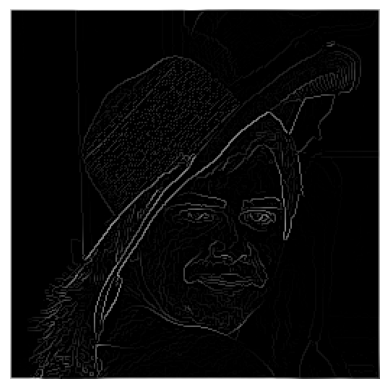

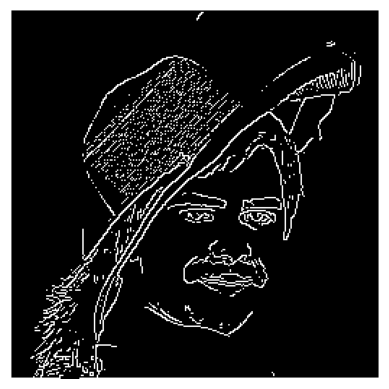

In [1559]:
nms = non_max_suppression_vectorized(norm, angle)
edge_detected = final_thresholding(nms)

show_tensor_image(nms)
show_tensor_image(edge_detected)

In [1560]:
def apply_mask_on_original(original: torch.Tensor, mask: torch.Tensor):
    if len(mask.shape) < len(original.shape):
        mask = mask.unsqueeze(0)
    if mask.shape != original.shape:
        mask = transforms.Resize(
            original.shape[1:], 
            interpolation=transforms.InterpolationMode.NEAREST
        )(mask)
    
    green = torch.Tensor([0, 1.0, 0])
    original = original.permute(1, 2, 0)
    original /= 2
    original[mask.squeeze()] = green
    show_tensor_image(original.permute(2, 0, 1))

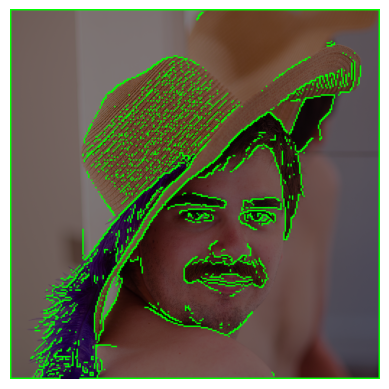

In [1561]:
apply_mask_on_original(read_image("Lenny_1024.png"), edge_detected)

In [1562]:
def canny(image_name: str, pooling_type: str = "avg", threshold: float = 0.12):
    input_image = read_image(image_name)
    
    greyscale = convert_to_grayscale(input_image)
    pooled = image_pooling(greyscale, pooling_type)
    blurred = gaussian_blur(pooled)
    
    norm, angle = apply_sobel_filters(blurred)
    nms = non_max_suppression_vectorized(norm, angle)
    final = final_thresholding(nms, threshold)
    return final

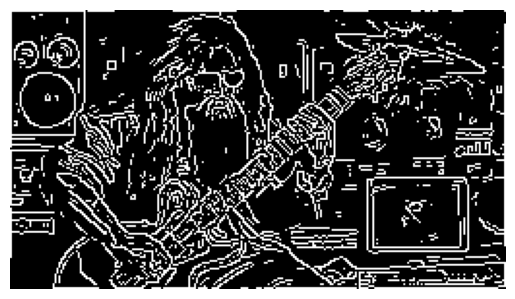

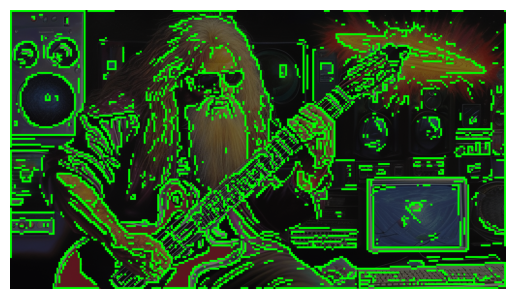

In [1563]:
show_tensor_image(canny("upel.png"))
apply_mask_on_original(read_image("upel.png"), canny("upel.png"))

### Opencv implementation

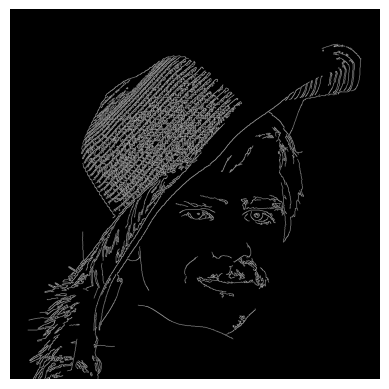

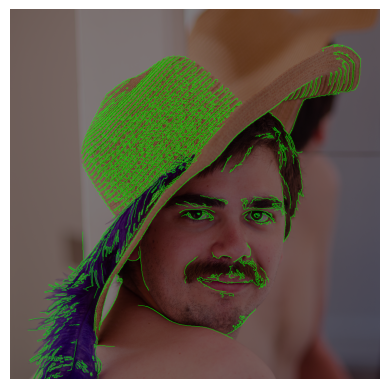

In [1569]:
import cv2

img = Image.open("Lenny_1024.png").convert('RGB')
canny = cv2.Canny(cv2.GaussianBlur(np.array(img), [3, 3], 0), 60, 200, None, 3, 1)
show_tensor_image(canny)

apply_mask_on_original(pil_to_tensor(img), pil_to_tensor(canny).bool())